# 이미지 데이터에 LIME 적용하기
### 사람 얼굴 분류 모델의 의사결정에서 주요 판단에 작용한 영역 표기

# 데이터 셋 가져오기

In [25]:
cd /content/drive/MyDrive/xai

/content/drive/MyDrive/xai


In [26]:
pip install scikit-image==0.18.3

In [27]:
'''
사용할 데이터인 올리비티얼굴은 1992년 ~1994년까지 케임브리지 AT&T 랩에서 수집한 이미지 데이터이다.

40명의 얼굴 이미지를 각각 10장씩 촬영
400장의 사진
8비트 흑백
64*64 크기
'''

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray, gray2rgb
from skimage.util import montage as montage2d

from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()

#이미지 흑백변환 후 LIME이 처리할 수 있는 형태로 전처리
X_vec = np.stack([gray2rgb(iimg)
                    for iimg in faces.data.reshape((-1,64,64))],0) 

#   faces.data이미지 한장에 대해 이미지 크기를 64*64에 맞추어 재조정 
#   전처리 후 데이터셋은(400,64,64,3)의 크기로 바뀜. 이미지 개수, 이미지 크기 , 컬러채널(RGB)을 각각 의미한다.

y_vec = faces.target.astype(np.uint8) #얼굴 이미지에 대한 레이블을 정수형으로 저장



## 불러온 얼굴데이터 확인

(-0.5, 1279.5, 1279.5, -0.5)

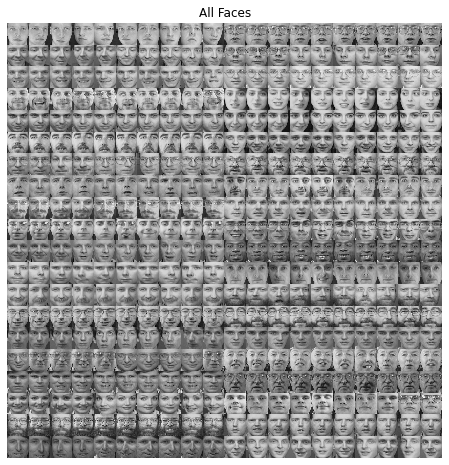

In [28]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1,figsize = (8,8))
ax1.imshow(montage2d(X_vec[:,:,:,0]),
           cmap = 'gray',interpolation = 'none') # montage2d는 직렬 이미지를 정사각형태로 그려낸다.
ax1.set_title('All Faces')
ax1.axis('off')

## 이미지 데이터 한장 표현

(-0.5, 63.5, 63.5, -0.5)

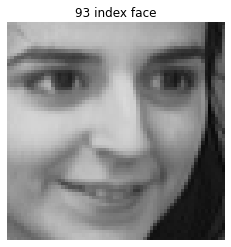

In [29]:
index = 93
plt.imshow(X_vec[index], cmap = 'gray')
plt.title('{} index face'.format(index))
plt.axis('off')

In [30]:
def predict_proba(image):
    return session.run(model_predict,
                       feed_dict = {preprocessed_image: image})

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train , y_test = train_test_split(X_vec,
                                                     y_vec,
                                                     train_size =.70)

# 이미지 전처리 수행 파이프라인

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

class PipeStep(object):
    def __init__(self,step_func):
        self._step_func = step_func

    def fit(self, *args):
        return self
    def transform(self,X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list:
                         [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list:
                        [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
        ('Make Gray', makegray_step),
        ('Flatten Image', flatten_step),
        ('MLP', MLPClassifier(
            activation = 'relu',
            hidden_layer_sizes = (400,40),
            random_state=1
        ))
])

In [33]:
simple_pipeline.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('Make Gray', <__main__.PipeStep object at 0x7f64f1195f90>),
                ('Flatten Image', <__main__.PipeStep object at 0x7f64f1195fd0>),
                ('MLP',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(400, 40),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=1, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

## 모델 정확도 F1 Score 출력하기

In [34]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true = y_test,y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         2
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         1
           4       0.25      0.50      0.33         2
           5       0.75      0.75      0.75         4
           6       1.00      1.00      1.00         2
           7       0.60      0.75      0.67         4
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       0.00      0.00      0.00         3
          12       0.25      0.50      0.33         2
          13       0.50      1.00      0.67         3
          14       0.40      0.50      0.44         4
          15       1.00      0.25      0.40         4
          16       0.67      0.67      0.67         3
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 데이터 전처리
### 정규화를 통해 각 피처간 편차가 큰 구간을 줄이고, 편차가 작은 구간의 변별력을 키워줌
 ### 결과적으로 local minimum에 빠질 가능성을 줄여주고 학습시 빠르게 모델이 수렴할 수 있도록함

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier

class PipeStep(object):
    def __init__(self,step_func):
        self._step_func = step_func

    def fit(self, *args):
        return self
    def transform(self,X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list:
                         [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list:
                        [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
        ('Make Gray', makegray_step),
        ('Flatten Image', flatten_step),
        ('Normalize', Normalizer()),
        ('MLP', MLPClassifier(
            activation = 'relu',
            hidden_layer_sizes = (400,40),
            random_state=1
        ))
])

simple_pipeline.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('Make Gray', <__main__.PipeStep object at 0x7f64f11954d0>),
                ('Flatten Image', <__main__.PipeStep object at 0x7f64f1195210>),
                ('Normalize', Normalizer(copy=True, norm='l2')),
                ('MLP',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(400, 40),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=1, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=F

In [36]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true = y_test,y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.50      1.00      0.67         2
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         1
           4       0.40      1.00      0.57         2
           5       0.67      1.00      0.80         4
           6       1.00      1.00      1.00         2
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      0.67      0.80         3
          12       0.50      1.00      0.67         2
          13       0.75      1.00      0.86         3
          14       0.80      1.00      0.89         4
          15       1.00      0.50      0.67         4
          16       1.00      0.67      0.80         3
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 파라미터 수정하기

In [37]:
simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flattten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('MLP', MLPClassifier(
        activation ='relu',
        alpha = 1e-7,
        epsilon = 1e-6,
        hidden_layer_sizes = (800,120),
        random_state =1
    )),
])

simple_pipeline.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('Make Gray', <__main__.PipeStep object at 0x7f64f11954d0>),
                ('Flattten Image',
                 <__main__.PipeStep object at 0x7f64f1195210>),
                ('Normalize', Normalizer(copy=True, norm='l2')),
                ('MLP',
                 MLPClassifier(activation='relu', alpha=1e-07,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=1, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                      

In [38]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true = y_test,y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         1
           4       0.67      1.00      0.80         2
           5       0.80      1.00      0.89         4
           6       0.50      1.00      0.67         2
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      0.67      0.80         3
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         4
          15       0.67      0.50      0.57         4
          16       1.00      0.67      0.80         3
          17       0.33    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# XAI를 적용시켜 인공지능 모델에 해설기능 추가

### 서브모듈(슈퍼픽셀) 분할 알고리즘 선언

In [39]:
pip install lime

In [40]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()



segmenter = SegmentationAlgorithm('slic',
                                  n_segments = 100,
                                  compactness =1,
                                  sigma = 1)
# slic: 슈퍼픽셀 분할 알고리즘
# n_segments : 분할개수
# compactness : 분할조각으로부터 유사한 파트 합치는 함수
# sigma : 분할 이미지를 부드럽게 깎이주는 정도

In [41]:
%%time

olivetti_test_index = 0

exp = explainer.explain_instance(X_test[olivetti_test_index],
                    classifier_fn = simple_pipeline.predict_proba,
                    top_labels=6,
                    num_samples=1000,
                    segmentation_fn=segmenter)

/usr/local/lib/python3.7/dist-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 2.42 s, sys: 974 ms, total: 3.39 s
Wall time: 1.96 s


In [42]:
from skimage.color import label2rgb

Text(0.5, 1.0, 'Show mask onlly')

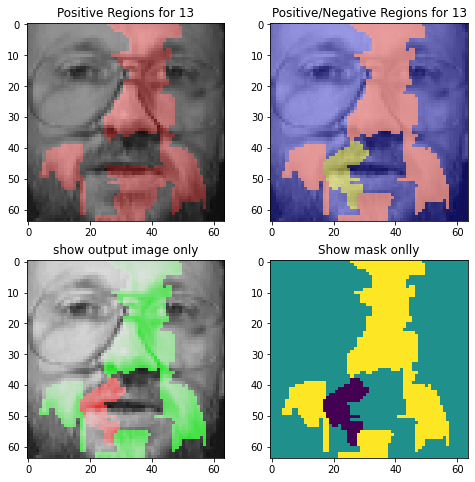

In [43]:
fig, ((ax1,ax2) , (ax3 , ax4)) = plt.subplots(2,2, figsize =(8,8))

temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                    positive_only = True,
                                    num_features=8,
                                    hide_rest = False)

temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                    positive_only = True,
                                    num_features = 8,
                                    hide_rest =False)

ax1.imshow(label2rgb(mask, temp, bg_label = 0),
           interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[olivetti_test_index]))

# show all segments
temp , mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                     positive_only = False,
                                     num_features = 8,
                                     hide_rest =False)

ax2.imshow(label2rgb(4 - mask, temp, bg_label = 0),
           interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[olivetti_test_index]))

# show only image
ax3.imshow(temp, interpolation = 'nearest')
ax3.set_title('show output image only')

# show only mask
ax4.imshow(mask, interpolation = 'nearest')
ax4.set_title('Show mask onlly')

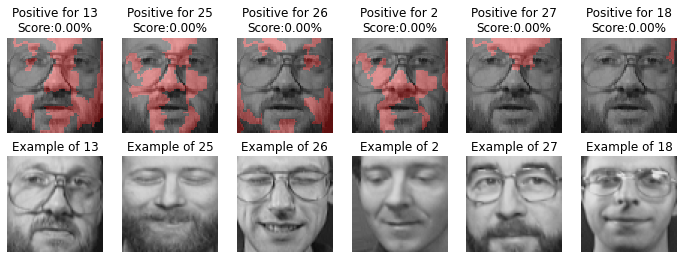

In [49]:
olivetti_test_index =24

fig, m_axs = plt.subplots(2,6,figsize = (12,4))
for i , (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask = exp.get_image_and_mask(i,
                                        positive_only =True,
                                        num_features =12,
                                        hide_rest=False,
                                        min_weight=0.001)
    
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0),
                interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:.2f}%'.format(i,
                    100*pipe_pred_prop[olivetti_test_index,i]))
    c_ax.axis('off')

    face_id = np.random.choice(np.where(y_train==i)[0])

    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')